In [1]:
from itertools import product

import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

# Helper Functions

In [2]:
def run_model(X, y):
    # Split datasets for training and testing
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=0,
        train_size=0.8
    )
    
    # Instantiate model with given hyperparameters
    model = GradientBoostingRegressor(
        n_estimators=10,
    )
    
    # fit the model on one set of data
    model.fit(X_train, y_train)  
    
    # evaluate the model on the second set of data
    y_test_predict = model.predict(X_test)
    return model, np.sqrt(mean_squared_error(y_test, y_test_predict))

In [3]:
def direction_to_numbers(X):
    direction = {'E':0, 'N':90, 'NE':45, 'NW':135, 'S':270, 'SE':315, 'SW':225, 'W':180}
    
    X["EntryHeading"] = X["EntryHeading"].apply(lambda x:direction[x])
    X["ExitHeading"] = X["ExitHeading"].apply(lambda x:direction[x])
    return X

In [4]:
def turn_degrees(X):
    X["TurnDegree"] = (X["EntryHeading"]-X["ExitHeading"]).apply(lambda x: x if abs(x) <=180 else (x+360 if x<0 else x-360))
    X["TurnDegree"] = X["TurnDegree"].apply(lambda x: x if x != -180 else x*-1)
    return X

In [5]:
def train_model(X_train, y_train, X_test,
                Model=GradientBoostingRegressor, model_args={'n_estimators': 100}):
    """ Train a scikit-learn model and return the predicted variable. """
    model = Model(**model_args)
    model.fit(X_train, y_train)  
    return model.predict(X_test)

In [6]:
def write_solution(df_test, out_name='solution.csv'):
    """ Write out a solution file in Kaggle's requested format.
    Arguments
    ---------
    df_test : pd.DataFrame
        Pandas dataframe with rows for each test sample in 'test.csv'
        and the 6 variables being scored on as columns.
    out_name : str
        The output file name.
    """
    dims = df_test.shape
    vals = df_test.stack().to_numpy()
    labels = [f'{row}_{col}' for row, col in product(range(dims[0]), range(dims[1]))]

    df_out = pd.DataFrame(
        {'Target': vals},
        index=labels
    )
    df_out.index.name = 'TargetId'
    df_out.to_csv(out_name + '.zip', compression='zip')

### Load Data

In [7]:
df_train = pd.read_csv('Data/train.csv')
df_test = pd.read_csv('Data/test.csv')

percentiles = [20, 40, 50, 60, 80]
not_in_test = [f'TotalTimeStopped_p{i}' for i in percentiles]
not_in_test += [f'TimeFromFirstStop_p{i}' for i in percentiles]
not_in_test += [f'DistanceToFirstStop_p{i}' for i in percentiles]

y = df_train['TotalTimeStopped_p80']

# Initial performance comparison

In [8]:
# Just drop all the string columns

X_0 = df_train.drop(columns=not_in_test + ['RowId', 'EntryStreetName', 'ExitStreetName', 'Path', 'City', 'EntryHeading', 'ExitHeading'])

model_0, score_0 = run_model(X_0, y)

In [9]:
# Convert entry and exit directions from string to degrees

X_1 = df_train.drop(columns=not_in_test + ['RowId', 'EntryStreetName', 'ExitStreetName', 'Path', 'City'])
X_1 = direction_to_numbers(X_1)

model_1, score_1 = run_model(X_1, y)

In [10]:
# Additionally calculate the angle in degrees the cars are turning

X_2 = df_train.drop(columns=not_in_test + ['RowId', 'EntryStreetName', 'ExitStreetName', 'Path', 'City'])
X_2 = direction_to_numbers(X_2)
X_2 = turn_degrees(X_2)

model_2, score_2 = run_model(X_2, y)

In [11]:
# Additionally add one hot encoding for City.

X_3 = df_train.drop(columns=not_in_test + ['RowId', 'EntryStreetName', 'ExitStreetName', 'Path'])
X_3 = direction_to_numbers(X_3)
X_3 = turn_degrees(X_3)
X_3 = pd.get_dummies(X_3, columns=['City'])

model_3, score_3 = run_model(X_3, y)

(25, 30)

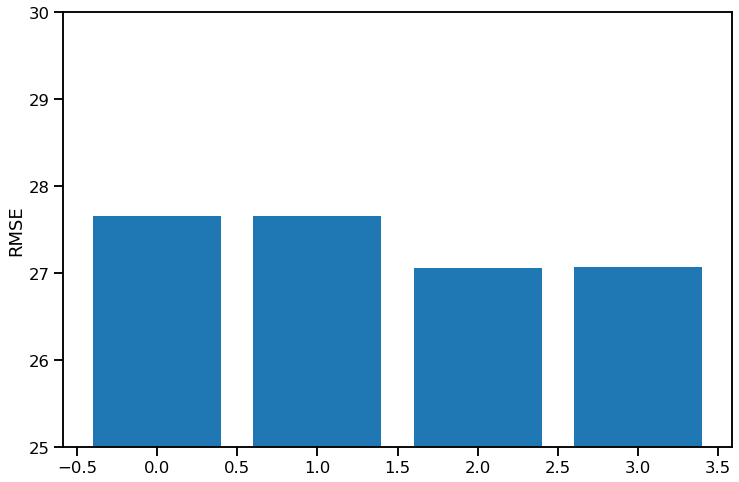

In [12]:
scores = [score_0, score_1, score_2, score_3]

fig, ax = plt.subplots(figsize=(12, 8))
plt.bar(range(len(scores)), scores, width=0.8)
plt.ylabel('RMSE')
plt.ylim([25, 30])

In [13]:
for i in zip(X_3.columns, model_3.feature_importances_):
    print(f'{i[0]}: {i[1]:0.5f}')

IntersectionId: 0.00000
Latitude: 0.04688
Longitude: 0.00469
EntryHeading: 0.00000
ExitHeading: 0.00000
Hour: 0.21991
Weekend: 0.04080
Month: 0.00000
TurnDegree: 0.61952
City_Atlanta: 0.00000
City_Boston: 0.00000
City_Chicago: 0.00000
City_Philadelphia: 0.06820


## Train over entire training sample and predict target variables for the test set

In [14]:
percentiles = [20, 50, 80]
test_vars = [f'TotalTimeStopped_p{i}' for i in percentiles]
test_vars += [f'DistanceToFirstStop_p{i}' for i in percentiles]

# Using X_2 as X_3 didn't get anywhere...
X_train = X_2
X_test = df_test.drop(columns=['RowId', 'EntryStreetName', 'ExitStreetName', 'Path', 'City'])
X_test = direction_to_numbers(X_test)
X_test = turn_degrees(X_test)

predictions = {}
for var in test_vars:
    clear_output(wait=True)
    print(f'Training to predict {var}')
    y_train = df_train[var]
    predictions[var] = train_model(
        X_train, y_train, X_test,
        Model=GradientBoostingRegressor,
        model_args={'n_estimators': 100, 'verbose': 1}
    )
df_predict = pd.DataFrame(predictions)

Training to predict DistanceToFirstStop_p80
      Iter       Train Loss   Remaining Time 
         1       23163.2395           47.42s
         2       23060.9458           44.68s
         3       22975.6533           41.95s
         4       22818.6169           40.40s
         5       22691.3982           39.61s
         6       22555.6977           37.34s
         7       22494.6014           36.41s
         8       22437.7438           35.90s
         9       22356.7341           34.78s
        10       22260.0647           33.70s
        20       21904.0679           28.73s
        30       21520.0457           24.35s
        40       21315.5945           20.41s
        50       21140.6660           16.89s
        60       20950.3102           13.30s
        70       20678.0775            9.87s
        80       20502.5257            6.55s
        90       20362.1182            3.25s
       100       20202.8996            0.00s


In [15]:
# Write out .csv file for submission
write_solution(df_predict)